In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as sps
import scipy.optimize


%matplotlib inline

In [2]:
import sys

In [27]:
sample = pd.read_csv('48-2.txt', header=None)

In [28]:
sample

,0
0,-3.573
1,-4.472
2,-2.624
3,-5.573
4,-2.806
5,-3.594
6,-2.601
7,-2.240
8,-5.382
9,-3.543


Гипотеза $H_0 : Q \in \mathcal{P} = \mathcal{N}(a, \sigma^2)$

Для нормального распределения очень хороши следующие оценки(например, из мм) $$\hat{a} = \overline{X}, \\ \hat{\sigma^2} = \overline{X^2} - \overline{X}^2$$

In [29]:
from sklearn.cross_validation import train_test_split

In [30]:
X_train, X_test, y_tr, y_te = train_test_split(sample, [0] * len(sample))

In [32]:
X_train.head()

,0
154,0.061
47,-2.951
75,-4.607
67,-4.536
139,-4.371


In [33]:
X_test.head()

,0
73,-1.024
134,-3.394
98,-7.544
35,-2.526
64,-1.040


Найдем оценки на тестовой выборке

In [40]:
len(sample)

200

In [41]:
len(X_train)

150

In [42]:
len(X_test)

50

In [37]:
top_a = X_train[0].mean()
top_sigma = (X_train[0] ** 2).mean() - top_a ** 2

In [39]:
print(top_a, top_sigma)

-3.46171333333 1.67048056449


Построим ЭФР по тестовой выборке и будем ее с ФР с оцененными нами параметрами. По теореме Гливенко-Кантели при размере выборки стремящемся к бесконечности супремум разности ЭФР и Настоящей равен 0

In [46]:
import statsmodels.tools

In [49]:
from statsmodels.tools.tools import ECDF

In [55]:
ecdf = ECDF(X_test[0])

In [61]:
train_dist = sps.norm(top_a, np.sqrt(top_sigma))

In [69]:
sample.describe()

,0
count,200.000000
mean,-3.361515
std,1.350431
min,-7.544000
25%,-4.322750
50%,-3.394500
75%,-2.599750
max,0.099000


In [68]:
ril_cdf = train_dist.cdf

In [70]:
dots = np.linspace(-7.7, 0.5, num=1000)

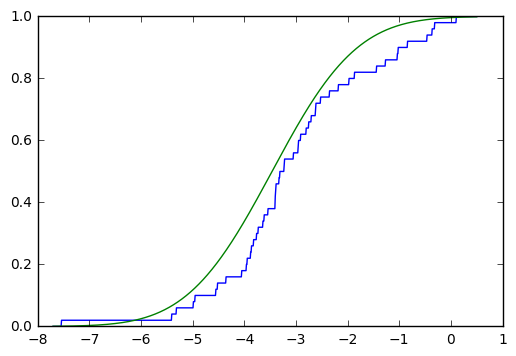

In [72]:
plt.plot(dots,ecdf(dots))
plt.plot(dots,ril_cdf(dots))

In [77]:
from sklearn.metrics import mean_squared_error

In [78]:
mean_squared_error(ril_cdf(dots), ecdf(dots))

0.0045749491504895263

Видно, что ошибка совсем небольшая и мы не можем отвергнуть гипотезу нормальности

С высокой вероятностью данная мне выборка из нормального распределения, это подтверждается критерием Шапиро-Уилка и Q-Q графиком (:   Просто убедимся в этом


In [73]:
sps.shapiro(sample[0])

(0.9936078786849976, 0.5435149073600769)

[]

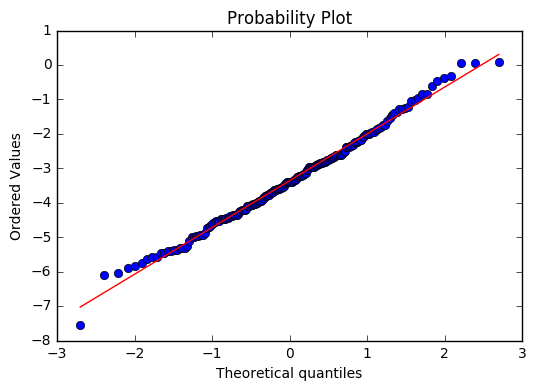

In [76]:
sps.probplot(sample[0], plot=plt)
plt.plot()

В общем метод будет таков: будем делать не одно разбиение а несколько, например, можно воспользоваться стратегией k-fold для кросс-валидации, для каждого строить оценки параметров, далее на тестовой ЭФР и на трейне реальную CDF, и смотреть MSE, например, усредним по всем разбиениям и посмотрим на значение если оно не сильно большое , то круто. Это несильно большое можно подобрать просто подав критерию плохое распределение(ненормальное), да посмотреть , насколько они будут отличаться


Понятно, что есть проблемы с тем, что есть , например , распределение Стьюдента, график плотности которого почти не отличим от нормального начиная с 30 степеней свободы вроде

Чтобы добиться результата получше, можно искать не просто оценки на параметры, а еще и эффективные или оптимальные. На небольшихх входных данных(размере выборки) лучше вообще использовать байесовский подхожд к оцениванию параметров, он будет лучше


Были еще идеи взять какие-нибудь статистики, значения которых будут сильно другими, если взять выборку не из нормального распределения. Думал нормализовать и сложить квадраты - получим распределение хи-квадрат(если верна гипотеза нормальности). Еще был вариант использовать распределение Фишера или Стьюдента, но благодаря ЦПТ при дотаточно большой выборке у нас они будут похожи друг на друга